## Домашнее задание к лекции «Поиск выбросов и генерация новых признаков»

Взять датасет www.kaggle.com...t/overview
Провести EDA с упором на пропущенные значения
Обучить простую модель несколько раз (см. ниже) и сравнить качество.
При обучении модели постепенно заполнять пропуски. При заполнении пропусков обосновывать выбранный тип метода заполнения.
Сгенерировать не менее новых 5 признаков (генерация с помощью PolynomialFeatures считать как один признак) и обучить модель после каждого добавления нового признака для контроля качества.
Построить изменения качества график качества модели на каждом шаге (после каждого заполнения пропусков в очередном признаке и после каждого добавления нового признака)

## Комментарий:
В итоге мне не удалось добиться нормального результата (обучения).
Возможно это связано с тем что я взял для работы очень ограниченный дата фрейм (по столбцам).
Ограничил принудительно.

Пробовал разные варианты по заполнению данных. В работе представлены один из вариантов.
На самом деле попробывал очень много всего.
При заполнении score как правило у меня уменьшался.
Иногда score по не понятным мне причинам падал даже до -923

1. Score на данных без обработки = 0.40392545569857086
2. Score после чистки данных = 0.4307597908264106
3. Score после всех моих манипуляций = 0.4163056144200409

0. Лучший Score = 0.4711209103609737. Добился я его на голых данных, обработав категориальные переменную product_type

В целом моя логика следующая:
1. Очищал данные;
2. Добавлял данные;
3. Генерировал новые признаки.

In [210]:
# подгружаю библиотеки:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
# Чтение файла
data = pd.read_csv('train.csv')
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB


In [213]:
data.shape

(30471, 292)

### Слишком большой датафрейм.
Ограничу для данной работы кол-во столбцов.
Прекрасно понимаю что это негативно отразится на обучении модели...

In [214]:
# сразу убрал id и timestamp
data_new = copy.copy(data[['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',\
                 'state','product_type', 'sub_area','price_doc']])
data_new

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
0,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,5850000
1,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,6000000
2,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,5700000
3,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,13100000
4,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...
30466,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,3.0,Investment,Otradnoe,7400000
30467,86,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,3.0,Investment,Tverskoe,25000000
30468,45,NaN,10.0,20.0,1.0,NaN,1.0,1.0,1.0,OwnerOccupier,Poselenie Vnukovskoe,6970959
30469,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,2.0,Investment,Obruchevskoe,13500000


In [215]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   full_sq       30471 non-null  int64  
 1   life_sq       24088 non-null  float64
 2   floor         30304 non-null  float64
 3   max_floor     20899 non-null  float64
 4   material      20899 non-null  float64
 5   build_year    16866 non-null  float64
 6   num_room      20899 non-null  float64
 7   kitch_sq      20899 non-null  float64
 8   state         16912 non-null  float64
 9   product_type  30471 non-null  object 
 10  sub_area      30471 non-null  object 
 11  price_doc     30471 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 2.8+ MB


30471 строк и 13 колонок (одна из них - целевая)
Много пропусков
Значения: числовые и строковые (object)

## Посмотрю на целевую переменную...

In [216]:
data_new.price_doc.value_counts()

2000000    757
1000000    747
6000000    372
3000000    332
6500000    330
          ... 
4708271      1
5883821      1
7335848      1
7376804      1
6037500      1
Name: price_doc, Length: 9296, dtype: int64

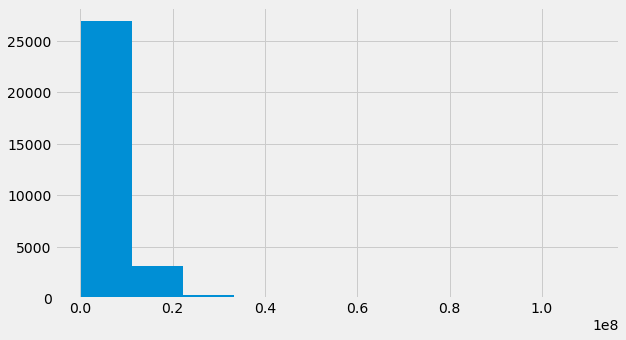

In [217]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [9,5]

plt.hist(data_new.price_doc)
plt.show()

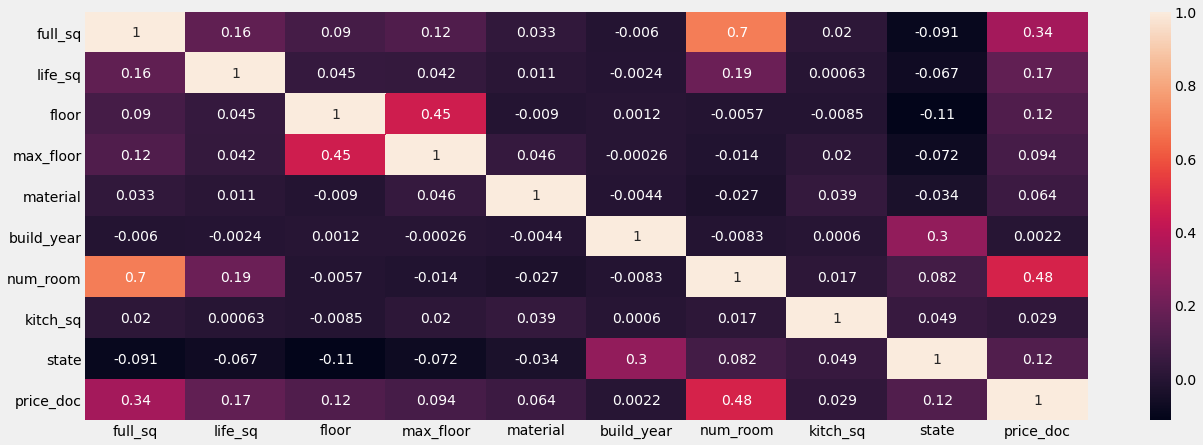

In [218]:
# посмотрю на значимость параметров и ограничу данные
plt.figure(figsize=(20, 7))
sns.heatmap(data=data_new.corr(), annot=True)
plt.show()

#### Вижу, что больше всего влияют (последняя строка): num_room, ful_sq, life_sq, floor, state
Этими колонками и займусь...

In [219]:
data_new.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
count,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,3.047100e+04
mean,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,7.123035e+06
std,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,4.780111e+06
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000e+05
25%,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,4.740002e+06
50%,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,6.274411e+06
75%,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,8.300000e+06
max,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,1.111111e+08


In [220]:
# Буду использовать линейную регрессию для того чтобы понять как хорошо или плохо сказываются изменения в данных
# на качестве работы моодели.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Определяю нужные функции:

In [221]:
def get_boxplot(X, columns=[]):
    for i in columns:
        sns.boxplot(x=X[i])
    pass 

In [222]:
def get_one_hot(X, cols):
    for each in cols:
        dummies = pd.get_dummies(X[each], prefix=each, drop_first=False)
        X = pd.concat([X, dummies], axis=1)
    return X.drop(columns=cols)

In [223]:
def get_score(ddaa):
    # print(ddaa.info())
    DATA_v = ddaa.drop('price_doc', axis=1)
    target_v = ddaa['price_doc']
    
    model = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(DATA_v, target_v, test_size=0.3, random_state=42)  
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [224]:
def get_value(X, column, mode='mean', value=0, columns_for_reg=None): 
    if mode == 'value':
        X.loc[X[X[column].isna()].index ,column] = value # заполнение значением
    elif mode == 'max':
        X.loc[X[X[column].isna()].index ,column] = X[column].max() # заполнение max
    elif mode == 'min':
        X.loc[X[X[column].isna()].index ,column] = X[column].min()  # заполнение min
    elif mode == 'median':
        X.loc[X[X[column].isna()].index ,column] = X[column].median()    # заполнение медианой
    elif mode == 'mode':
        X.loc[X[X[column].isna()].index, column] = X[column].mode()[0]   # заполнение модой
    elif mode == 'indicator': # метод индикатора (принимает значение 1 при наличие пропуска и 0 в остальных случаях)
        X['ind_'+str(column)] = 0
        X.loc[X[X[column].isna()].index, 'ind_'+str(column)] = 1
        X.loc[X[X[column].isna()].index, column] = 0     
    elif mode == 'linreg':   # линейная регрессия
        if columns_for_reg is None:
            cols = list(X.select_dtypes([np.number]).columns) 
            cols.remove(column)
        else:
            cols = columns_for_reg
        X_tmp = X.dropna()  
        m = LinearRegression().fit(X_tmp[cols], X_tmp[column])
        X.loc[X[X[column].isna()].index, column] = m.predict(X[X[column].isna()][cols])
    else:
        X.loc[X[X[column].isna()].index, column] = X[column].mean()  # по умолчанию среднее значение
    return X.head(3)

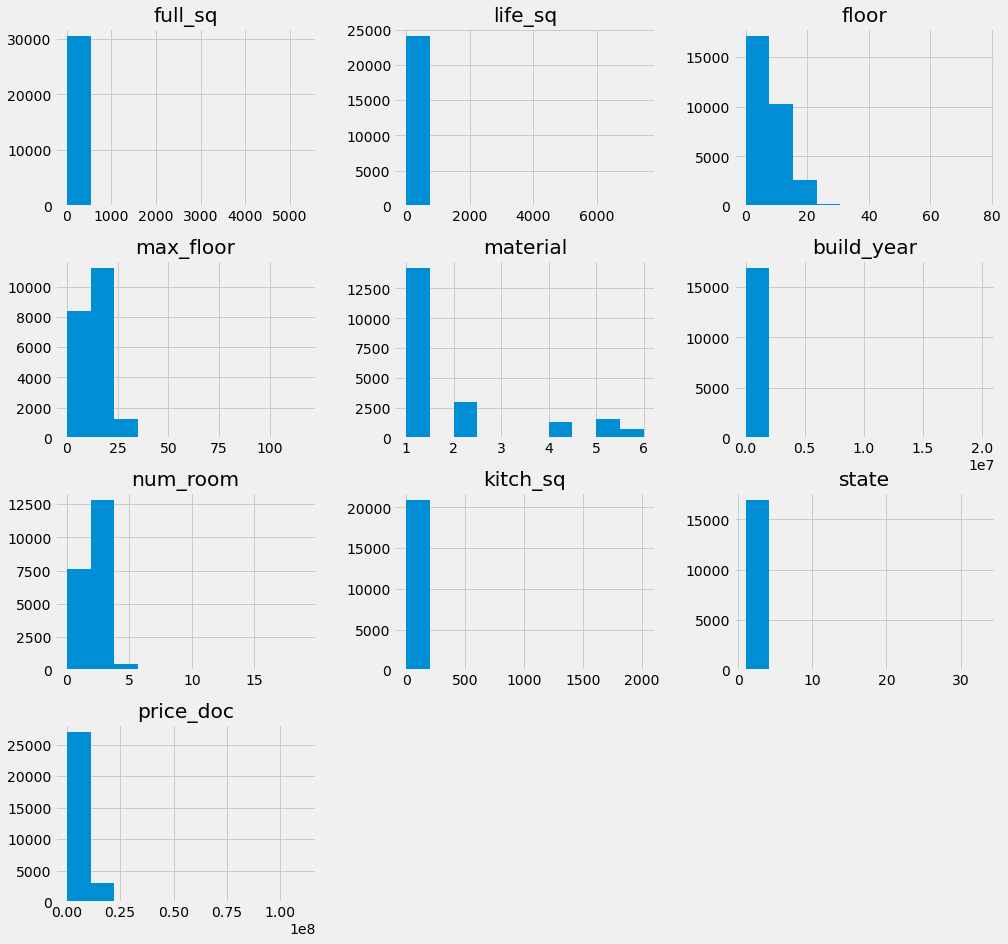

In [225]:
data_new.hist(figsize = (15,15))
plt.show()

In [226]:
# Количество пропусков по столбцам:
data_new.isnull().sum()

full_sq             0
life_sq          6383
floor             167
max_floor        9572
material         9572
build_year      13605
num_room         9572
kitch_sq         9572
state           13559
product_type        0
sub_area            0
price_doc           0
dtype: int64

# Первоначальное обучение на данных как есть...

In [227]:
# выкидываю пока столбцы, которые мешают обучению...
cols = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
        'state','price_doc']
get_score(data.dropna()[cols])

0.40392545569857086

# Результат плачевный... 0.40392545569857086
### Начинаю работать со столбцами

In [228]:
# Сперва обработаю категориальные переменные
# 1. Столбец product_type. пропусков у него нет
data['product_type'].unique()

array(['Investment', 'OwnerOccupier'], dtype=object)

In [229]:
# разбиваю на столбцы. Оригинал удаляю
data1 = get_one_hot(data_new, ['product_type'])
data1.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,price_doc,product_type_Investment,product_type_OwnerOccupier
0,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Bibirevo,5850000,1,0
1,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Nagatinskij Zaton,6000000,1,0
2,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Tekstil'shhiki,5700000,1,0
3,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Mitino,13100000,1,0
4,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Basmannoe,16331452,1,0


In [230]:
cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']
get_score(data1.dropna()[cols1])

0.4711209103609737

# + около 7% к score. Пока не так и плохо.

In [ ]:
# num_room, ful_sq, life_sq, floor

# займусь очисткой данных
# пока score должен падать

In [237]:
# Столбец num_room
# Пропуски есть.
data1.isnull().sum()

full_sq                           0
life_sq                        6383
floor                           167
max_floor                      9572
material                       9572
build_year                    13605
num_room                       9572
kitch_sq                       9572
state                         13559
sub_area                          0
price_doc                         0
product_type_Investment           0
product_type_OwnerOccupier        0
dtype: int64

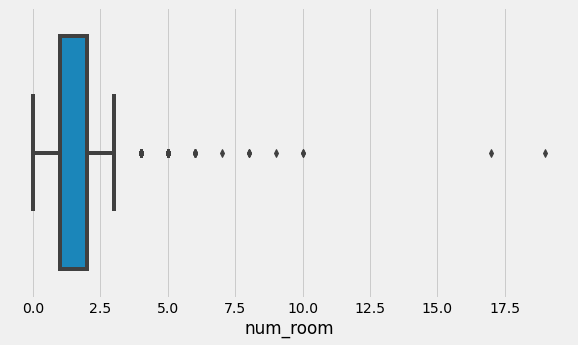

In [238]:
# Смотрим выбросы:
get_boxplot(data1, columns = ['num_room'])

In [239]:
data1[(data1['num_room'] > 9) | (data1['num_room'] < 1)]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,price_doc,product_type_Investment,product_type_OwnerOccupier
10452,48,NaN,15.0,0.0,1.0,2013.0,0.0,0.0,1.0,Tekstil'shhiki,7675120,0,1
11183,40,NaN,11.0,0.0,4.0,0.0,0.0,0.0,1.0,Poselenie Shherbinka,3422309,0,1
11621,40,19.0,17.0,17.0,1.0,2011.0,19.0,7.0,3.0,Poselenie Vnukovskoe,2630000,1,0
11791,54,NaN,24.0,0.0,1.0,0.0,0.0,0.0,1.0,Mitino,8383079,0,1
15992,58,NaN,10.0,0.0,1.0,NaN,0.0,0.0,NaN,Poselenie Vnukovskoe,6632021,0,1
17764,58,34.0,1.0,2.0,1.0,1992.0,10.0,10.0,2.0,Krjukovo,6000000,1,0
17932,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Poselenie Voskresenskoe,4425000,0,1
18123,112,112.0,3.0,3.0,1.0,0.0,0.0,0.0,1.0,Zapadnoe Degunino,7600002,0,1
18669,209,209.0,0.0,3.0,4.0,2007.0,0.0,0.0,1.0,Poselenie Shherbinka,10500000,1,0
20670,79,NaN,4.0,0.0,1.0,NaN,0.0,0.0,NaN,Nekrasovka,7402800,0,1


In [240]:
# Есть и 0 значения.
# Это явно ошибки. Удалять пока не буду эти строки, а установлю значение NaN для этого столбца
data1.loc[(data1['num_room'] > 9) | (data1['num_room'] < 1), 'num_room'] = np.NaN
data1.isnull().sum()

full_sq                           0
life_sq                        6383
floor                           167
max_floor                      9572
material                       9572
build_year                    13605
num_room                       9590
kitch_sq                       9572
state                         13559
sub_area                          0
price_doc                         0
product_type_Investment           0
product_type_OwnerOccupier        0
dtype: int64

### увеличилось количество пропусков в num_room, но данные стали чище

In [241]:
cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']
get_score(data1.dropna()[cols1])

0.3442902420775442

## Score после этого снизился и сильно. Порядка 12-13%

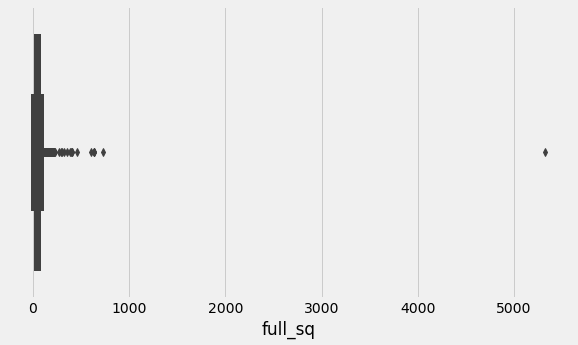

In [242]:
# full_sq
# Смотрим выбросы:
get_boxplot(data1, columns = ['full_sq'])

In [243]:
data1[(data1['full_sq'] > 500) | (data1['full_sq'] < data1['life_sq']) | (data1['full_sq'] < 10)]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,price_doc,product_type_Investment,product_type_OwnerOccupier
1084,44,281.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Bibirevo,6200000,1,0
1188,9,44.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Veshnjaki,6300000,1,0
1822,18,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ljublino,5200000,1,0
1863,30,178.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Presnenskoe,5900000,1,0
2009,5,40.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Gol'janovo,5770000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26386,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Poselenie Moskovskij,5510645,0,1
26582,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Nagornoe,10145891,0,1
26925,1,1.0,17.0,1.0,1.0,1.0,1.0,1.0,1.0,Poselenie Desjonovskoe,3793778,0,1
27154,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Nagornoe,15318960,0,1


In [244]:
# Это явно ошибки. Удалять пока не буду эти строки, а установлю значение NaN для этого столбца
data1.loc[(data1['full_sq'] > 500) | (data1['full_sq'] < data1['life_sq']) | (data1['full_sq'] < 10), 'full_sq'] = np.NaN
data1.isnull().sum()

full_sq                          65
life_sq                        6383
floor                           167
max_floor                      9572
material                       9572
build_year                    13605
num_room                       9590
kitch_sq                       9572
state                         13559
sub_area                          0
price_doc                         0
product_type_Investment           0
product_type_OwnerOccupier        0
dtype: int64

In [245]:
cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']
get_score(data1.dropna()[cols1])

0.461711059458103

## Score опять подрос на 12%

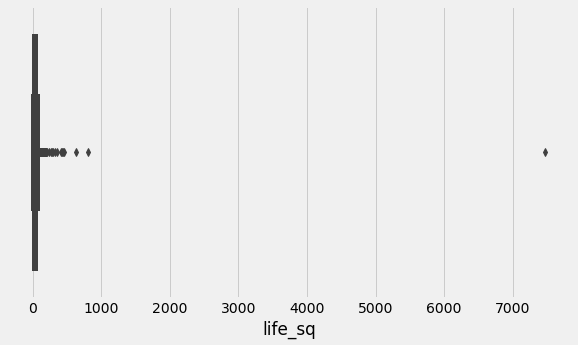

In [246]:
# life_sq
# Смотрим выбросы:
get_boxplot(data1, columns = ['life_sq'])

In [247]:
data1[(data1['life_sq'] > 500) | (data1['life_sq'] < 1)]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,price_doc,product_type_Investment,product_type_OwnerOccupier
858,78.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Nekrasovka,552312,1,0
1596,59.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Nekrasovka,338570,1,0
2778,38.0,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,Nekrasovka,675205,1,0
3426,71.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Nekrasovka,1438647,1,0
3800,57.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,Poselenie Moskovskij,5049071,0,1
4138,61.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Tverskoe,4618597,0,1
4311,44.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Poselenie Sosenskoe,4741970,0,1
5879,61.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Nekrasovka,5419778,0,1
9646,NaN,802.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Chertanovo Juzhnoe,12031350,0,1
10275,37.0,0.0,6.0,17.0,1.0,2013.0,1.0,0.0,1.0,Nekrasovka,3824904,0,1


In [248]:
# Это явно ошибки. Удалять пока не буду эти строки, а установлю значение NaN для этого столбца
data1.loc[(data1['life_sq'] > 500) | (data1['life_sq'] < 1), 'life_sq'] = np.NaN
data1.isnull().sum()

full_sq                          65
life_sq                        6431
floor                           167
max_floor                      9572
material                       9572
build_year                    13605
num_room                       9590
kitch_sq                       9572
state                         13559
sub_area                          0
price_doc                         0
product_type_Investment           0
product_type_OwnerOccupier        0
dtype: int64

In [249]:
cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']
get_score(data1.dropna()[cols1])

0.449257686853911

## Score немного снизился.

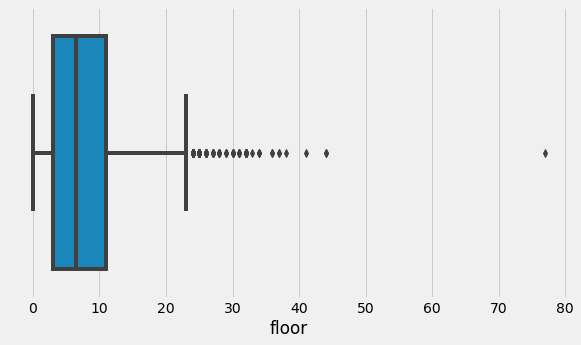

In [250]:
# floor
# Смотрим выбросы:
get_boxplot(data1, columns = ['floor'])

In [251]:
data1[(data1['floor'] > 40) | (data1['floor'] < 1)]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,price_doc,product_type_Investment,product_type_OwnerOccupier
2499,64.0,54.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,Jakimanka,13000000,1,0
5085,157.0,75.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Poselenie Krasnopahorskoe,5000000,1,0
5333,181.0,79.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Poselenie Krasnopahorskoe,4500000,1,0
15363,58.0,NaN,0.0,0.0,6.0,0.0,1.0,0.0,1.0,Poselenie Vnukovskoe,6867981,0,1
17932,NaN,NaN,0.0,0.0,1.0,0.0,NaN,0.0,1.0,Poselenie Voskresenskoe,4425000,0,1
18669,209.0,209.0,0.0,3.0,4.0,2007.0,NaN,0.0,1.0,Poselenie Shherbinka,10500000,1,0
21222,74.0,74.0,0.0,0.0,1.0,2015.0,2.0,0.0,1.0,Poselenie Sosenskoe,5802830,0,1
21606,74.0,38.0,41.0,48.0,4.0,2013.0,2.0,5.0,3.0,Jakimanka,14500000,1,0
21921,160.0,160.0,0.0,3.0,2.0,0.0,3.0,0.0,1.0,Tverskoe,7267500,0,1
23584,57.0,33.0,77.0,22.0,1.0,1986.0,2.0,10.0,3.0,Lomonosovskoe,13700000,1,0


In [252]:
# Это явно ошибки. Удалять пока не буду эти строки, а установлю значение NaN для этого столбца
data1.loc[(data1['floor'] > 40) | (data1['floor'] < 1), 'floor'] = np.NaN
data1.isnull().sum()

full_sq                          65
life_sq                        6431
floor                           180
max_floor                      9572
material                       9572
build_year                    13605
num_room                       9590
kitch_sq                       9572
state                         13559
sub_area                          0
price_doc                         0
product_type_Investment           0
product_type_OwnerOccupier        0
dtype: int64

In [253]:
cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']
get_score(data1.dropna()[cols1])

0.39871270993852503

## Score опять сильно снизился

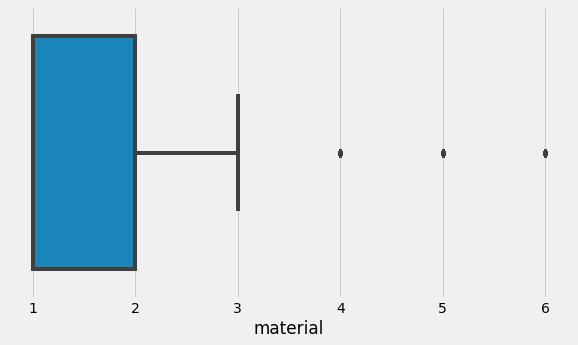

In [254]:
# Смотрим выбросы material:
get_boxplot(data1, columns = ['material'])

In [256]:
data1[(data1['material'] < 1)]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,price_doc,product_type_Investment,product_type_OwnerOccupier


In [ ]:
### В данном случае нечего чистить...

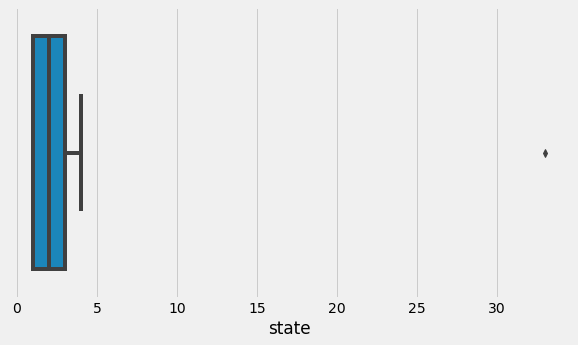

In [257]:
# Смотрим выбросы state:
get_boxplot(data1, columns = ['state'])

In [258]:
data7[(data7['state'] > 5) | (data1['state'] < 1)]

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,state,sub_area,price_doc,product_type_Investment,product_type_OwnerOccupier,material_-999.0,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0
10089,37.0,16.0,1.0,12.0,20052009.0,1.0,9.0,33.0,Cheremushki,9000000,1,0,0,1,0,0,0,0,0


In [259]:
# Один явный выброс.
# меняю значение на NaN
data1.loc[(data1['state'] > 5) | (data1['state'] < 1), 'state'] = np.NaN
data1.isnull().sum()

full_sq                          65
life_sq                        6431
floor                           180
max_floor                      9572
material                       9572
build_year                    13605
num_room                       9590
kitch_sq                       9572
state                         13560
sub_area                          0
price_doc                         0
product_type_Investment           0
product_type_OwnerOccupier        0
dtype: int64

In [260]:
cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']
get_score(data1.dropna()[cols1])

0.4307597908264106

## Score чуток повысился, но не так сильно...

# На этом чистку данных закончу...

# Начну восстанавливать данные (дозаполнять)

In [261]:
# Заполню life_sq
data2 = copy.copy(data1)
# get_value(data2, 'life_sq', mode='value', value=data2['life_sq']+17)
# get_value(data2, 'life_sq', mode='mean')
# get_value(data2, 'life_sq', mode='median')
# get_value(data2, 'life_sq', mode='min')
get_value(data2, 'life_sq', mode='max')
# get_value(data2, 'life_sq', mode='mode')

#data2.isnull().sum()

# cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
cols1 = ['full_sq','life_sq','floor','max_floor','material','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']
get_score(data2.dropna()[cols1])

0.449826385910002

In [262]:
# Заполню full_sq
data3 = copy.copy(data2)
get_value(data3, 'full_sq', mode='value', value=data3['life_sq']+16)
# get_value(data2, 'life_sq', mode='mean')
# get_value(data2, 'life_sq', mode='median')
# get_value(data2, 'life_sq', mode='min')
# get_value(data2, 'life_sq', mode='max')
# get_value(data2, 'life_sq', mode='mode')
#data3.isnull().sum()

# cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
cols1 = ['full_sq','life_sq','floor','max_floor','material','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']
get_score(data3.dropna()[cols1])

0.43342058152287466

In [263]:
data3.isnull().sum()

full_sq                           0
life_sq                           0
floor                           180
max_floor                      9572
material                       9572
build_year                    13605
num_room                       9590
kitch_sq                       9572
state                         13560
sub_area                          0
price_doc                         0
product_type_Investment           0
product_type_OwnerOccupier        0
dtype: int64

In [264]:
# Заполним пропущенный этаж
data4 = copy.copy(data3)
get_value(data4, 'floor', mode='value', value=1)
# get_value(data4, 'floor', mode='mean')
# get_value(data4, 'floor', mode='median')
# get_value(data2, 'life_sq', mode='min')
# get_value(data2, 'life_sq', mode='max')
# get_value(data4, 'floor', mode='mode')

# cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
cols1 = ['full_sq','life_sq','floor','max_floor','material','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']


get_score(data4.dropna()[cols1])

0.445295136648555

In [265]:
data4.isnull().sum()

full_sq                           0
life_sq                           0
floor                             0
max_floor                      9572
material                       9572
build_year                    13605
num_room                       9590
kitch_sq                       9572
state                         13560
sub_area                          0
price_doc                         0
product_type_Investment           0
product_type_OwnerOccupier        0
dtype: int64

In [266]:
data4

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,price_doc,product_type_Investment,product_type_OwnerOccupier
0,43.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Bibirevo,5850000,1,0
1,34.0,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Nagatinskij Zaton,6000000,1,0
2,43.0,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Tekstil'shhiki,5700000,1,0
3,89.0,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Mitino,13100000,1,0
4,77.0,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Basmannoe,16331452,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,44.0,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,3.0,Otradnoe,7400000,1,0
30467,86.0,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,3.0,Tverskoe,25000000,1,0
30468,45.0,458.0,10.0,20.0,1.0,NaN,1.0,1.0,1.0,Poselenie Vnukovskoe,6970959,0,1
30469,64.0,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,2.0,Obruchevskoe,13500000,1,0


In [267]:
# Заполним кол-во комнат
data5 = copy.copy(data4)
get_value(data5, 'num_room', mode='value', value=1)
# get_value(data5, 'num_room', mode='mean')
# get_value(data5, 'num_room', mode='median')
# get_value(data5, 'num_room', mode='min')
# get_value(data5, 'num_room', mode='max')
# get_value(data5, 'num_room', mode='mode')

# cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
cols1 = ['full_sq','life_sq','floor','max_floor','material','num_room','kitch_sq',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']


get_score(data5.dropna()[cols1])

0.41693509550781105

In [268]:
data5.isnull().sum()

full_sq                           0
life_sq                           0
floor                             0
max_floor                      9572
material                       9572
build_year                    13605
num_room                          0
kitch_sq                       9572
state                         13560
sub_area                          0
price_doc                         0
product_type_Investment           0
product_type_OwnerOccupier        0
dtype: int64

In [269]:
# material
data6 = copy.copy(data5)
get_value(data6, 'material', mode='value', value=-999)
data6 = get_one_hot(data6, ['material'])
# data6

# cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
cols1 = ['full_sq','life_sq','floor','max_floor','num_room','kitch_sq',
         'material_-999.0','material_1.0','material_2.0','material_3.0','material_4.0','material_5.0','material_6.0',
        'state','price_doc','product_type_Investment','product_type_OwnerOccupier']


get_score(data6.dropna()[cols1])

0.4306335570574149

In [271]:
# state
data7 = copy.copy(data6)
get_value(data7, 'state', mode='value', value=-999)
data7 = get_one_hot(data7, ['state'])
# data7

# cols1 = ['full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
cols7 = ['full_sq','life_sq','floor','max_floor','num_room','kitch_sq',
          'material_-999.0','material_1.0','material_2.0','material_3.0','material_4.0','material_5.0','material_6.0',
         'state_-999.0','state_1.0','state_2.0','state_3.0',
         'price_doc','product_type_Investment','product_type_OwnerOccupier']


get_score(data7.dropna()[cols7])

0.4134865359115639

## Попробую добавить новые параметры:

In [272]:
# Добавлю новый параметр
data8 = copy.copy(data7)
data8 = data8.assign(new_par1 = data8.full_sq * data8.life_sq * data8.num_room)

In [273]:
cols8 = ['full_sq','life_sq','floor','max_floor','num_room','kitch_sq',
          'material_-999.0','material_1.0','material_2.0','material_3.0','material_4.0','material_5.0','material_6.0',
         'state_-999.0','state_1.0','state_2.0','state_3.0','new_par1',
         'price_doc','product_type_Investment','product_type_OwnerOccupier']


get_score(data8.dropna()[cols8])

0.4163056144200442

In [274]:
# Добавлю новый параметр не жилая площадь 
data9 = copy.copy(data8)
data9 = data9.assign(new_par2 = data9.full_sq - data9.life_sq)

In [275]:
cols9 = ['full_sq','life_sq','floor','max_floor','num_room','kitch_sq',
          'material_-999.0','material_1.0','material_2.0','material_3.0','material_4.0','material_5.0','material_6.0',
         'state_-999.0','state_1.0','state_2.0','state_3.0','new_par1','new_par2',
         'price_doc','product_type_Investment','product_type_OwnerOccupier']


get_score(data9.dropna()[cols9])

0.4163056144200409